In [1]:
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
DIR = '/media/gautam/projects/sdrcc/'

data = pd.read_csv(DIR+'training_data/final.csv')

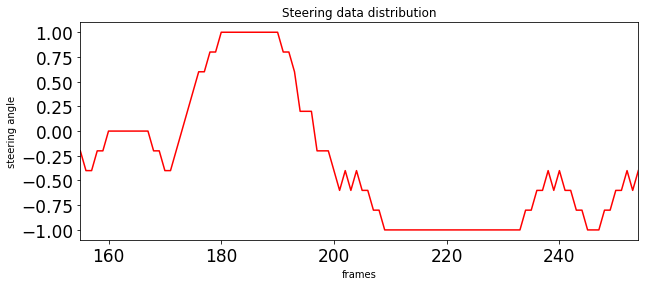

In [3]:
random_index = int(random.random()*500)
data.mean_last_5_frames[random_index:random_index+100].plot(title='Steering data distribution', fontsize=17, figsize=(10,4), color='r')
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.show()


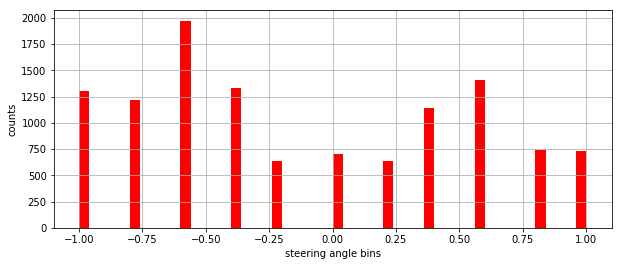

In [4]:
plt.figure(figsize=(10,4))
data.mean_last_5_frames.hist(bins=50, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()


## Clean up steps:
* Downsample the over represented examples
* Upsample the under represented examples
* Expose more varied examples to try and represent a uniform distribution.

In [5]:
# prepare dataset
data = data[['id', 'mean_last_5_frames']]
data = data.rename(index=str, columns={'id': 'frame_id', 'mean_last_5_frames': 'steering_angle'})
# random shuffle
data = data.sample(frac=1).reset_index(drop=True)
print("Dataset size after random shuffling:", len(data))

Dataset size after random shuffling: 11827


Dataset size after downsampling over-represented examples: 9846


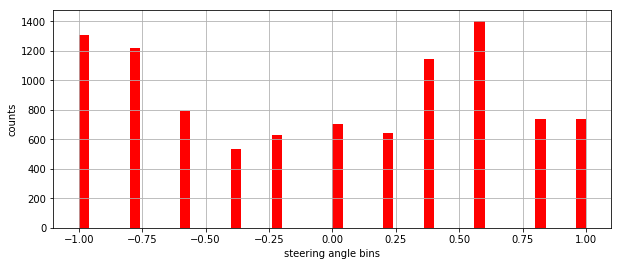

In [6]:
# randomly drop 40% of examples clustering near steering angle -> -0.50
data = data.drop(data.query('-0.625 < steering_angle < -0.375').sample(frac=.6).index)

plt.figure(figsize=(10,4))
data.steering_angle.hist(bins=50, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Dataset size after downsampling over-represented examples:", len(data))

Dataset size (approx) after flipping: 19692


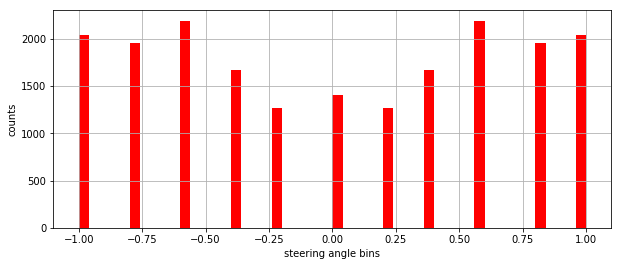

In [7]:
# check to see what will be the distribution of steering angles after flipping imgs (probability of flipping is 50%)
test_angs = data.steering_angle.values.tolist() + data.steering_angle.apply(lambda x: x*-1).tolist()

plt.figure(figsize=(10,4))
df = pd.DataFrame(test_angs, columns=['angs'])
df.angs.hist(bins=50, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Dataset size (approx) after flipping:", len(test_angs))

## Augmentation 1: Brightness augmentation 

In [8]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

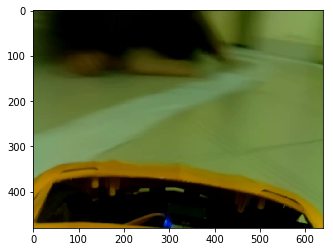

In [9]:
import random
image2 = cv2.imread(DIR+'training_data/final_image_data/'+data.frame_id.values[int(random.random()*100)]+'.jpg')
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
plt.imshow(image2)
plt.show()

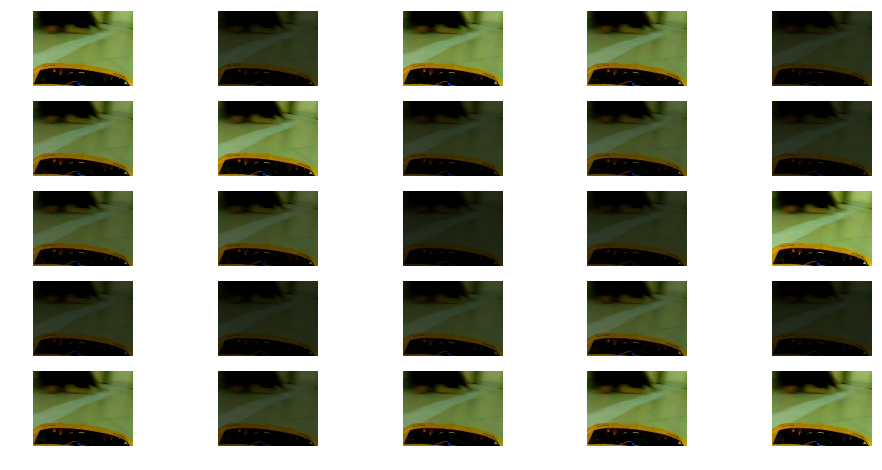

In [10]:
plt.figure(figsize=(16,8))
for i in range(25):
    image1 = augment_brightness(image2)
    plt.subplot(5,5,i+1)
    plt.imshow(image1)
    plt.axis('off')
plt.show()

## Augmentation 2: Shifting left/right and up/down 

Maximum shift of upto 10 pixels and applying angle change of .2 per pixel

In [11]:
random_index = int(random.random()*500)
image = cv2.imread(DIR+'training_data/final_image_data/'+data.frame_id.values[random_index]+'.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
steer = data.steering_angle.values[random_index]

In [12]:
rows,cols,channels = image.shape

In [13]:
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr,steer_ang,tr_x

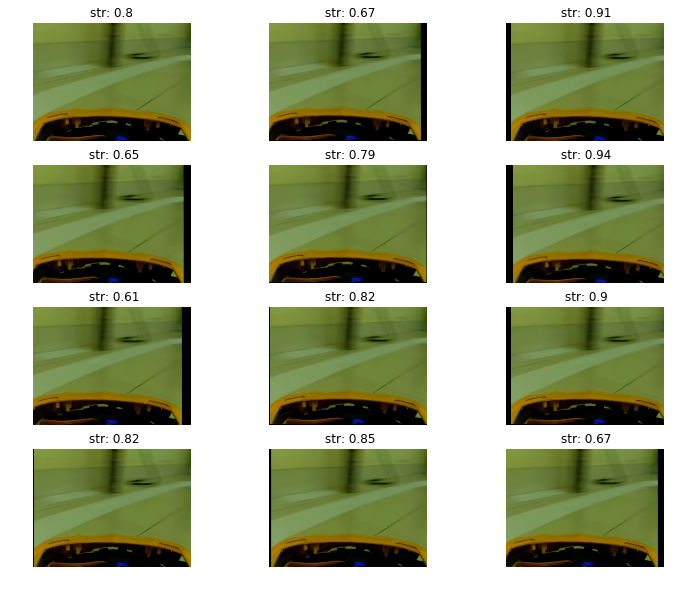

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x = trans_image(image,steer,80)
    plt.title(' str: '+str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');
plt.show()

## Augmentation 3: Flipping

In [15]:
new_size_col = 64
new_size_row = 64

def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image 

def preprocess_image_file_train(line_data):
    random_index = 0
    path_file = DIR+'training_data/final_image_data/'+line_data.loc[random_index,'frame_id']+'.jpg'
    shift_ang = 0.
    y_steer = line_data.loc[random_index,'steering_angle'] + shift_ang
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer,tr_x = trans_image(image,y_steer,150)
    image = augment_brightness(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

def preprocess_image_file_predict(line_data):
    random_index = 0
    path_file = DIR+'training_data/final_image_data/'+line_data.loc[random_index,'frame_id']+'.jpg'
    image = cv2.imread(path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = image/255.-.5
    image = preprocessImage(image)
    image = np.array(image)
    return image    

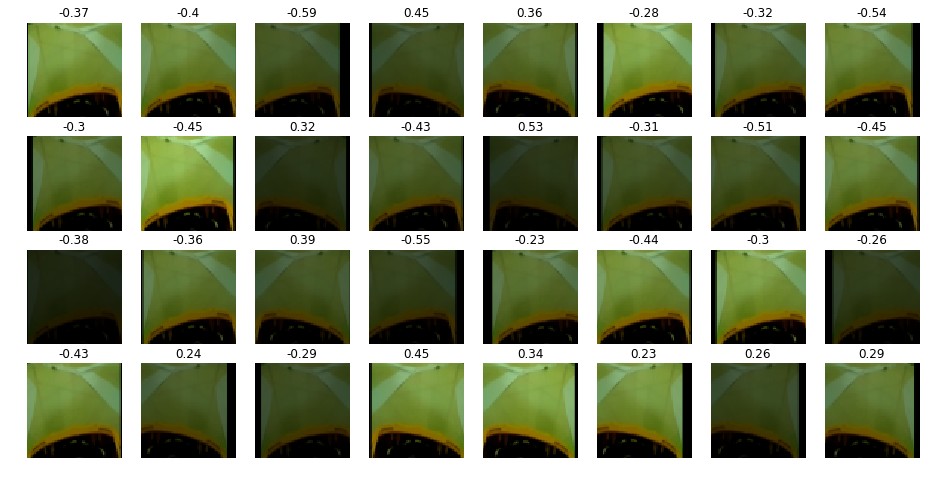

In [16]:
line_data = data.reset_index(drop=True)
plt.figure(figsize=(16,8))
for i in range(32):
    image,steer = preprocess_image_file_train(line_data)

    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))
plt.show()

In [17]:
pr_threshold = 1

def generate_train_from_PD_batch(data, batch_size=32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
            batch_steering[batch_steering>1] = 1.
        yield batch_images, batch_steering

In [18]:
def generate_train_from_PD(data):
    while 1:
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        x,y = preprocess_image_file_train(line_data)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        if y > 1:
            y = 1.
        y = np.array([[y]])
        yield x, y

def generate_valid_from_PD(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steering_angle'][0]
            if y > 1:
                y = 1.
            y = np.array([[y]])
            yield x, y

        
valid_s_generator = generate_valid_from_PD(data)

In [3]:
for i in range(100):
    next(valid_s_generator)
img,steer = next(valid_s_generator)
plt.imshow(img[0]);
plt.axis('off')
plt.title(str(np.round(steer,4)));
plt.show()

NameError: name 'valid_s_generator' is not defined

## Model

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

ImportError: No module named 'keras'

In [21]:
import tensorflow as tf
tf.python.control_flow_ops = tf
new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))

model.add(Convolution2D(3,1,1,
                        border_mode='valid',
                        name='conv0', init='he_normal'))pppppppppp
model.add(ELU())

model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv1', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv6', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512,name='hidden1', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', init='he_normal'))

In [22]:
adam = Adam(lr=1e-3)

model.compile(optimizer=adam,
          loss='mse')

In [23]:
from pathlib import Path
import json
import os

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

In [24]:
val_size = len(data)
pr_threshold = 1

batch_size = 256Deep-Learning-Nanodegree

i_best = 0
val_best = 1000

for i_pr in range(10):

    train_r_generator = generate_train_from_PD_batch(data,batch_size)

    nb_vals = np.round(len(data)/val_size)-1
    history = model.fit_generator(train_r_generator,
            samples_per_epoch=len(data), nb_epoch=10,validation_data=valid_s_generator,
                        nb_val_samples=val_size)
    
    fileModelJSON = 'model_' + str(i_pr) + '.json'
    fileWeights = 'model_' + str(i_pr) + '.h5'
    
    save_model(fileModelJSON,fileWeights)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)
    
    
    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

KeyboardInterrupt: 

9984/9846 [==============================] - 218s - loss: 18.0708 - val_loss: 0.7234
Epoch 2/10
9984/9846 [==============================] - 196s - loss: 2.6744 - val_loss: 0.7904

/opt/conda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 1/10
9728/9846 [============================>.] - ETA: 1s - loss: 18.4740   

In [0]:
len(data)